#### Name: Eric Lindgren
#### CID: ericlin
#### PSN: 970222-1954

## Deep neural network python class

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

#### Load the data

inputs: (n_data, pixel_width, pixel_height) = (1797, 8, 8)
                       with labels (n_data) = (1797,)

flattened input, X: (n_inputs, n_features)  = (1797, 64)


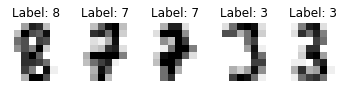

In [2]:
# import 
from sklearn import datasets

# ensure the same random numbers appear every time
np.random.seed(0)

# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print(f"inputs: (n_data, pixel_width, pixel_height) = {inputs.shape}")
print(f"                       with labels (n_data) = {labels.shape}")


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print(f"\nflattened input, X: (n_inputs, n_features)  = {inputs.shape}")


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {digits.target[random_indices[i]]:1}")

In [3]:
from sklearn.model_selection import train_test_split

# ensure the same random numbers appear every time
np.random.seed(0)

train_size = 0.7
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

print(f"Number of training images: {len(X_train):4}")
print(f"Number of test images:     {len(X_test):4}")

Number of training images: 1257
Number of test images:      540


In [4]:
# to categorical turns our integer vector into a onehot representation
# we implement it in in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

### Task 1: Full object oriented implementation

In [22]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def sigmoid(self, z):
        return 1./(1. + np.exp(-z))
    
    
    def softmax(z):
        '''Softmax activation function for the output layer.'''
        ax=0
        if isinstance(z[0], np.ndarray):
            'Check if a list, if so use matrix version of argmax.'
            ax=1
        return np.exp(z)/((np.exp(z)).sum(axis=ax)).reshape(-1,1)


    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

        
    def feed_forward(self):
        # feed-forward for training
        # Hidden layer
        self.z_h = self.X_data_full@self.hidden_weights + self.hidden_bias.T  # z_h
        self.a_h = sigmoid(z=self.z_h)  # a_h
        # Output layer
        self.z_o = self.a_h@self.output_weights + self.output_bias.T
        self.a_0 = softmax(self.z_o)

        
    def backpropagation(self):
        raise NotImplementedError("The backpropagation method does not yet include the regularizer.")
        
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        # Add the weight gradients from the regularizer term.
        # Add code here
        self.hidden_weights_gradient += lmbd*self.hidden_weights_gradient
        self.output_weights_gradient += lmbd*self.output_weights_gradient

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient


    def fixed_feed_forward(self, X):
        '''
        Performs a feed formward pass for input data X. For use exclusively by the predict and 
        predict_probabilities functions.
        '''
        z_h = X@self.hidden_weights + self.hidden_bias.T  # z_h
        a_h = sigmoid(z=self.z_h)  # a_h
        # Output layer
        z_o = self.a_h@self.output_weights + self.output_bias.T
        a_o = softmax(self.z_o)

        return a_o
        
    
    def predict(self, X):
        '''Return a vector of predictions for input X'''
        probabilities = fixed_feed_forward(X)
        if isinstance(probabilities[0], np.ndarray):
            'Check if a list, if so use matrix version of argmax.'
            class_label = probabilities.argmax(axis=1)  # Returns a number between 0-9 - the index
        else: 
            class_label = probabilities.argmax()
        return class_label

        
    def predict_probabilities(self, X):
        '''Return all of the probabilities for input X'''
        probabilities = fixed_feed_forward(X)
        return probabilities
    
        
    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

## Task 2

In [23]:
from sklearn.metrics import accuracy_score

epochs = 100
batch_size = 100

n_hidden_neurons = 50
n_categories = 10

eta=0.1
lmbd=0.

# ensure the same random numbers appear every time
np.random.seed(0)

dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)

In [26]:
print(f"Accuracy on training data before training: {accuracy_score(dnn.predict(X_train), Y_train):.3f}")

NameError: name 'fixed_feed_forward' is not defined